In [1]:
%cd ..

/mnt/e/projects/face_recognition


In [2]:
import os
from collections import defaultdict

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from IPython.display import clear_output
from sklearn.metrics.pairwise import cosine_similarity
from torch.utils.data import Dataset
from torchvision.models import efficientnet_v2_s

from dataset import get_data_train_and_data_irm, split_by_person

from config import CFG

device = "cuda"

In [3]:
train_data, data_irm = get_data_train_and_data_irm()
query_df, distractors_df = split_by_person(data_irm)

Число уникальных людей 10174. Всего фото 194716
Датасет для тренировки содержит 2026 людей
data 194716 -> train_data 60015 data_irm 134701
query_df 120 distractors_df 480


In [4]:
query_df.head(5)

,path,is_query,is_gallery,label,split
0,174098.jpg,None,None,97,valid
1,180366.jpg,None,None,97,valid
2,174972.jpg,None,None,97,valid
3,118283.jpg,None,None,10173,valid
4,126102.jpg,None,None,10173,valid


In [5]:
query_img_names = [os.path.join(CFG.img_folder_dst, x) for x in query_df["path"].values]

query_dict = defaultdict(list)
for img_name, img_class in query_df[["path", "is_query"]].values:
    query_dict[img_class].append(img_name)

distractors_img_names = [os.path.join(CFG.img_folder_dst, x) for x in distractors_df["path"].values]

In [6]:
best_model = efficientnet_v2_s()
best_model.classifier = nn.Sequential(nn.Dropout(p=0.2), nn.Linear(in_features=1280, out_features=2024))
best_model.load_state_dict(torch.load("models/efficientnet_v2_s_ce_10_epoch.pth"))
best_model.classifier = nn.Sequential()
best_model.eval()
None

In [7]:
class celebAIrDataset(Dataset):
    def __init__(self, images_list):
        self.images = images_list
        self.transform = A.Compose(
            [
                # A.Resize(height=128, width=128),
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ToTensorV2(),
            ]
        )

    def __len__(self):
        return len(self.images)

    def get_img(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return self.transform(image=img)["image"]

    def get_tensors(self):
        images = torch.stack([self.get_img(img_name) for img_name in self.images])
        return images

    def __getitem__(self, idx):
        img_name = self.images[idx]
        return self.get_img(img_name)

In [8]:
def compute_embeddings(model, images_list):
    """
    compute embeddings from the trained model for list of images.
    params:
      model: trained nn model that takes images and outputs embeddings
      images_list: list of images paths to compute embeddings for
    output:
      list: list of model embeddings. Each embedding corresponds to images
            names from images_list
    """
    data = celebAIrDataset(images_list)

    model.to(device)

    # loader = torch.utils.data.DataLoader(data.get_tensors(), batch_size=32, shuffle=False)
    loader = torch.utils.data.DataLoader(data, batch_size=32, shuffle=False)

    model.eval()
    embeddings = []
    with torch.no_grad():
        for x in loader:
            outputs = model(x.to(device))
            embeddings.append(outputs.cpu())
    return torch.cat(embeddings)

In [9]:
query_embeddings = compute_embeddings(best_model, query_img_names)
distractors_embeddings = compute_embeddings(best_model, distractors_img_names)

In [10]:
distractors_embeddings.size(), query_embeddings.size()

(torch.Size([480, 1280]), torch.Size([120, 1280]))

In [11]:
def compute_cosine_query_pos(query_dict, query_img_names, query_embeddings):
    """
    compute cosine similarities between positive pairs from query (stage 1)
    params:
      query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                  the dataset. Value: images corresponding to that class
      query_img_names: list of images names
      query_embeddings: list of embeddings corresponding to query_img_names
    output:
      list of floats: similarities between embeddings corresponding
                      to the same people from query list
    """
    full_embeddings = torch.Tensor()

    for person_class in query_dict:
        images = [os.path.join(CFG.img_folder_dst, x) for x in query_dict[person_class]]
        person_embeddings = []
        for image_path in images:
            person_embeddings.append(torch.Tensor(query_embeddings[query_img_names.index(image_path)]))
        if len(person_embeddings) == 0:
            person_embeddings = torch.Tensor
            result = 0.0
        else:
            person_embeddings = torch.stack(person_embeddings)
            result = cosine_similarity(np.array(person_embeddings), np.array(person_embeddings))
            df = pd.DataFrame(result)

            df = df.mask(np.tril(np.ones(df.shape, dtype=np.bool_))).values.reshape(-1)  # get triangle values
            useful_result = df[~np.isnan(df)]  # drop nan

            useful_result = torch.Tensor(useful_result).view(-1)
            full_embeddings = torch.cat((full_embeddings, useful_result))
    results = [i.item() for i in full_embeddings]
    plt.hist(results)
    plt.show()
    print("Count of cosine similarities =", len(results))
    return results

In [12]:
def compute_cosine_query_neg(query_dict, query_img_names, query_embeddings):
    """
    compute cosine similarities between negative pairs from query (stage 2)
    params:
      query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                  the dataset. Value: images corresponding to that class
      query_img_names: list of images names
      query_embeddings: list of embeddings corresponding to query_img_names
    output:
      list of floats: similarities between embeddings corresponding
                      to different people from query list
    """

    full_embeddings = torch.Tensor()
    class_counter = []

    k = 0
    for person_class in query_dict:
        k += 1
        print("Analyse {} person of {}...".format(k, len(query_dict)))
        images = [os.path.join(CFG.img_folder_dst, x) for x in query_dict[person_class]]
        class_counter.extend([person_class for _ in range(len(images))])

        person_embeddings = []
        for image_path in images:
            person_embeddings.append(torch.Tensor(query_embeddings[query_img_names.index(image_path)]))
        if len(person_embeddings) == 0:
            person_embeddings = torch.Tensor
        else:
            person_embeddings = torch.stack(person_embeddings)
            full_embeddings = torch.cat((full_embeddings, person_embeddings))
        clear_output(wait=True)

    # all_data = pd.DataFrame(data={"class": class_counter, "embeddings": list(full_embeddings)})
    results = cosine_similarity(full_embeddings, full_embeddings)
    results = pd.DataFrame(data=results, index=class_counter, columns=class_counter)

    k = 0
    for i in results:
        k += 1
        print("Analyse {} row of {}...".format(k, len(results)))
        results.loc[i, i] = np.nan
        clear_output(wait=True)

    df = results.mask(np.tril(np.ones(results.shape, dtype=np.bool_))).values.reshape(-1)  # get triangle values
    useful_result = df[~np.isnan(df)]  # drop nan
    plt.hist(useful_result)
    plt.show()
    print("Count of cosine similarities =", len(useful_result))
    return useful_result

In [13]:
def compute_cosine_query_distractors(query_embeddings, distractors_embeddings):
    """
    compute cosine similarities between negative pairs from query and distractors
    (stage 3)
    params:
      query_embeddings: list of embeddings corresponding to query_img_names
      distractors_embeddings: list of embeddings corresponding to distractors_img_names
    output:
      list of floats: similarities between pairs of people (q, d), where q is
                      embedding corresponding to photo from query, d —
                      embedding corresponding to photo from distractors
    """
    results = cosine_similarity(query_embeddings, distractors_embeddings)
    results = results.reshape(-1)
    plt.hist(results)
    plt.show()
    print("Count of cosine similarities =", len(results))
    return results

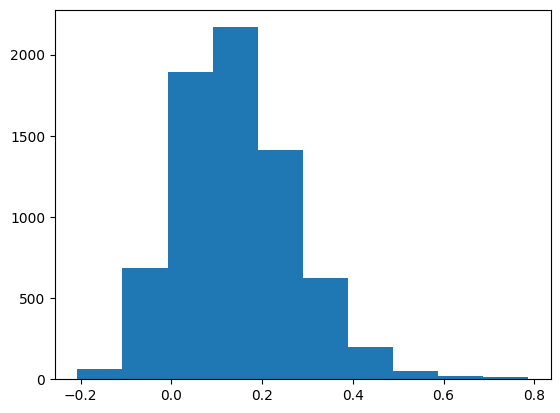

Count of cosine similarities = 7140


In [14]:
cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names, query_embeddings)

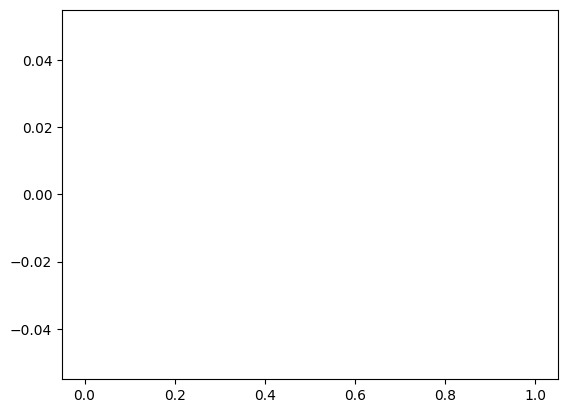

Count of cosine similarities = 0


In [15]:
cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names, query_embeddings)

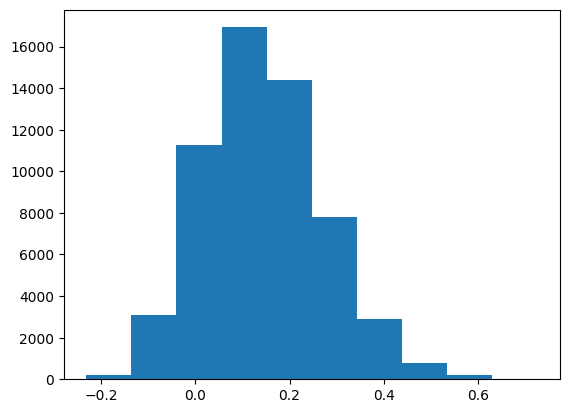

Count of cosine similarities = 57600


In [16]:
cosine_query_distractors = compute_cosine_query_distractors(query_embeddings, distractors_embeddings)

In [17]:
def compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, fpr=0.1):
    """
    compute identification rate using precomputer cosine similarities between pairs
    at given fpr
    params:
      cosine_query_pos: cosine similarities between positive pairs from query
      cosine_query_neg: cosine similarities between negative pairs from query
      cosine_query_distractors: cosine similarities between negative pairs
                                from query and distractors
      fpr: false positive rate at which to compute TPR
    output:
      float: threshold for given fpr
      float: TPR at given FPR
    """
    cosine_query_pos = torch.Tensor(cosine_query_pos)
    cosine_query_neg = torch.Tensor(cosine_query_neg)
    cosine_query_distractors = torch.Tensor(cosine_query_distractors)

    false_pairs = torch.cat((cosine_query_neg, cosine_query_distractors))
    N = round(fpr * len(false_pairs))
    false_pairs = torch.sort(false_pairs, descending=True)[0]
    threshold = false_pairs[N]
    TPR = len(cosine_query_pos[cosine_query_pos > threshold]) / len(cosine_query_pos)
    return threshold.item(), TPR

In [18]:
# фух компуктер не взорвался, но моя голова да
for frp in [0.5, 0.6, 0.7, 0.8]:
    print(compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, frp))

(0.13672997057437897, 0.480812324929972)
(0.10480313748121262, 0.5813725490196079)
(0.07190364599227905, 0.6908963585434174)
(0.03602030500769615, 0.7963585434173669)
